In [ ]:
import matplotlib.pyplot as plt

import optuna
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from datasets import LaserDataset
from models import MLP
from utils import train_model, validate_model, hypertune_objective, generate_predictions


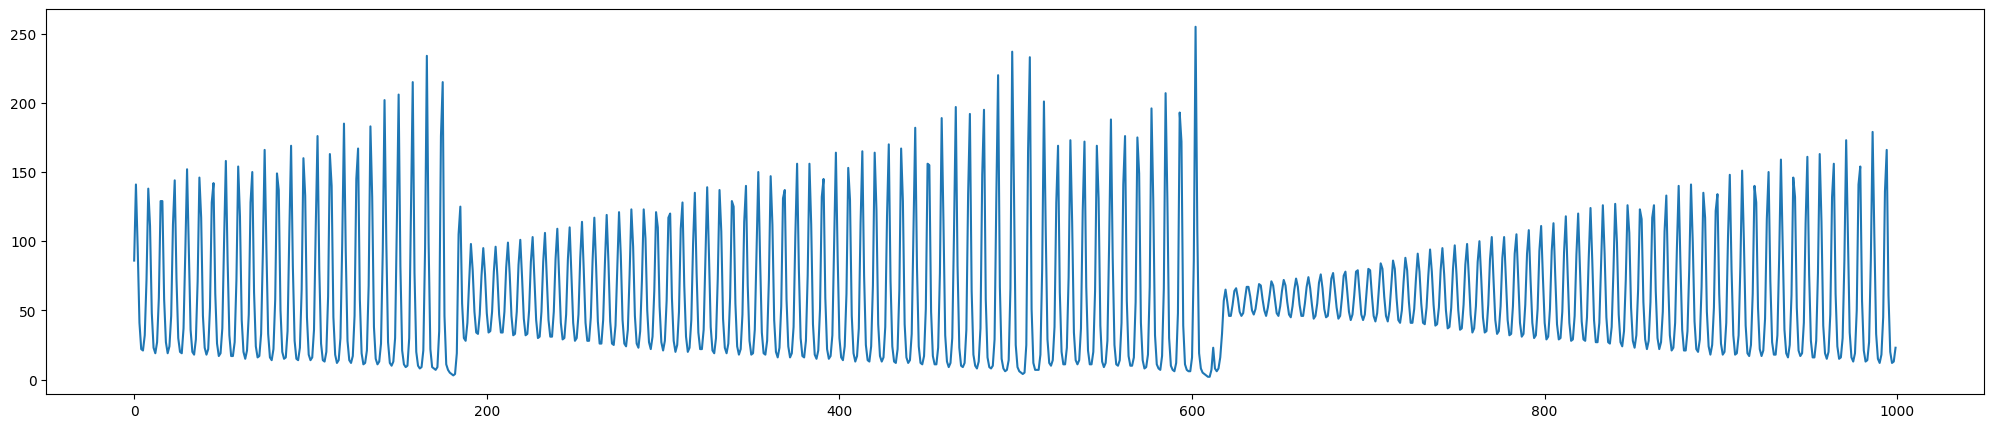

In [7]:
train_data = sio.loadmat('../data/Xtrain.mat')['Xtrain']

plt.figure(figsize=(25, 5))
plt.plot(train_data.flatten())


In [8]:
batch_size = 32
epochs = 10

loss_fn = nn.MSELoss()

model_cls = MLP
optim_cls = torch.optim.Adam
dataset_cls = LaserDataset


def suggest_hyperparameters(trial):
    # Data hyperparameters
    data_params = {
        'window_size': trial.suggest_int('window_size', 1, 5)
    }
    # Model hyperparameters
    model_params = {
        'hidden_size': trial.suggest_int('hidden_size', 32, 256),
    }
    # Optim hyperparams
    optim_params = {
        'lr': trial.suggest_loguniform('lr', 1e-5, 1e-1),
    }

    return data_params, model_params, optim_params


In [9]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: hypertune_objective(
    model_cls=model_cls,
    optim_cls=optim_cls,
    dataset_cls=dataset_cls,
    data=train_data,
    loss_fc=loss_fn,
    epochs=epochs,
    batch_size=batch_size,
    model_params=suggest_hyperparameters(trial)[1],
    optim_params=suggest_hyperparameters(trial)[2],
    data_params=suggest_hyperparameters(trial)[0],
), n_trials=5)

print(f"Best trial: {study.best_trial.params}")
print(f"Best validation loss: {study.best_trial.value}")


[I 2025-05-09 14:53:35,272] A new study created in memory with name: no-name-b6b753e7-a34a-4bb3-a607-6091435289cd
/var/folders/96/myqx4fm16sq0pxxklfdh9r8m0000gn/T/ipykernel_49448/501433203.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lr': trial.suggest_loguniform('lr', 1e-5, 1e-1),
[I 2025-05-09 14:53:36,357] Trial 0 finished with value: 544.6852537972586 and parameters: {'window_size': 4, 'hidden_size': 134, 'lr': 0.0027880678034234315}. Best is trial 0 with value: 544.6852537972586.
[I 2025-05-09 14:53:37,411] Trial 1 finished with value: 3395.353330775669 and parameters: {'window_size': 5, 'hidden_size': 230, 'lr': 2.9751201647524996e-05}. Best is trial 0 with value: 544.6852537972586.
[I 2025-05-09 14:53:38,449] Trial 2 finished with value: 2439.496780831473 and parameters: {'window_size': 3, 'hidden_size': 180, 'l

Best trial: {'window_size': 3, 'hidden_size': 216, 'lr': 0.07271413395049062}
Best validation loss: 524.9074807303293


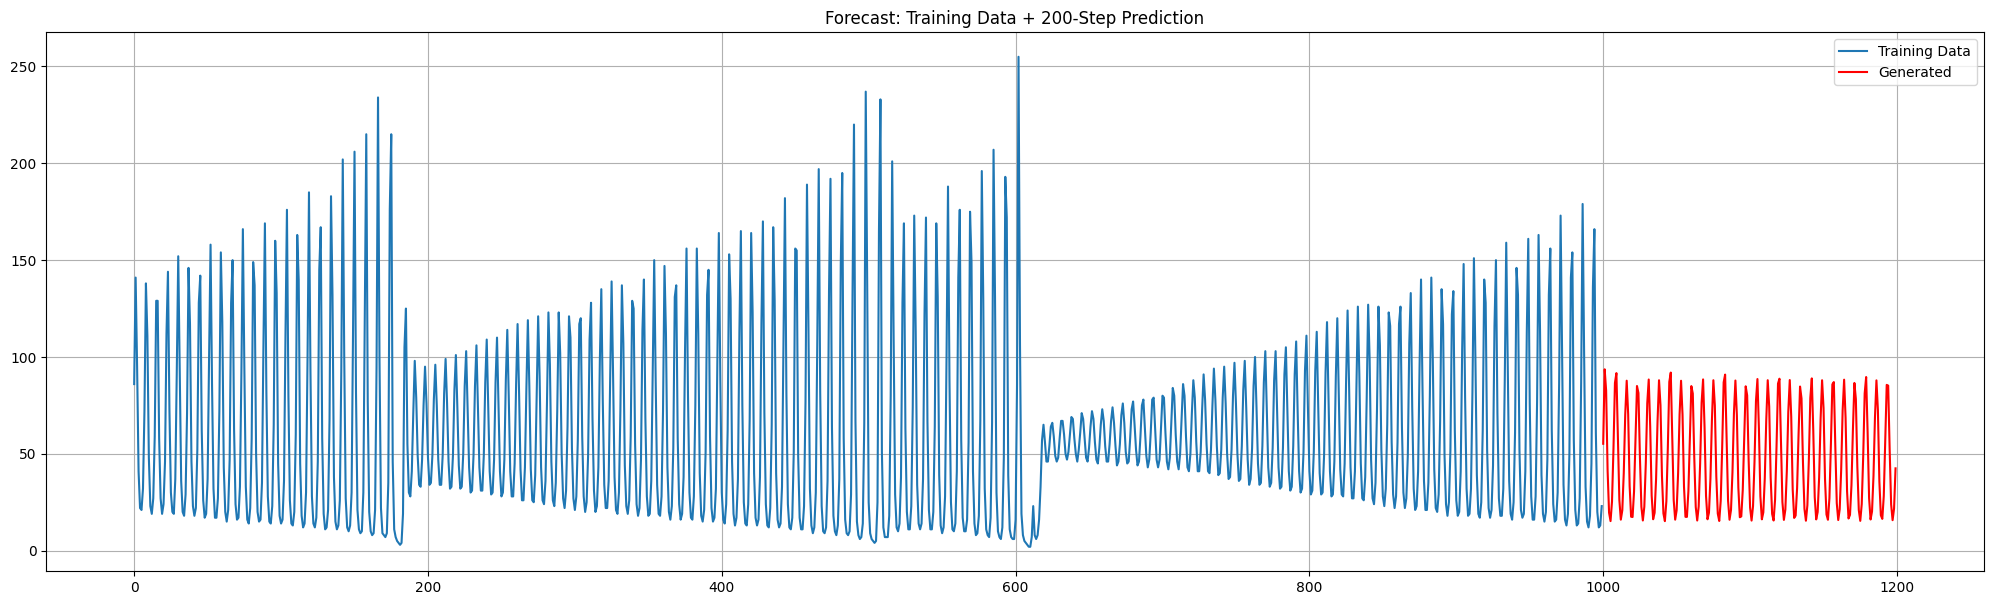

In [10]:
best_params = study.best_trial.params

dataset = LaserDataset(train_data, best_params['window_size'])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

model = model_cls(input_size=best_params['window_size'], hidden_size=best_params['hidden_size'])
optim = optim_cls(model.parameters(), lr=best_params['lr'])

train_model(dataloader, model, optim, loss_fn, epochs=epochs)
generate_predictions(model, train_data, best_params['window_size'])
